In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2017-04-01'
end_date = '2017-04-09'
spring_break_2017 = calc_temps(start_date, end_date)
spring_break_2017

[(67.0, 74.53571428571429, 80.0)]

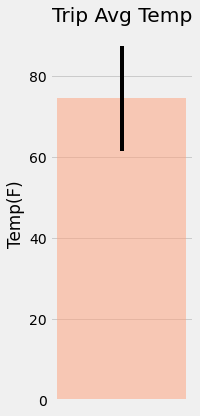

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
average = spring_break_2017[0][1]
peak_to_peak = spring_break_2017[0][2] - spring_break_2017[0][0]

plt.figure(figsize=(3,6))
plt.bar(average, average, yerr=peak_to_peak, color='lightsalmon', alpha=.5)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=True,    
    top=True,        
    labelbottom=False,
    grid_alpha=0)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_by_station = session.query(Measurements.station,
                                    Stations.name,
                                    Stations.latitude, 
                                    Stations.longitude,
                                    Stations.elevation, 
                                    func.sum(Measurements.prcp)).\
    filter(Measurements.station == Stations.station).\
    filter(Measurements.date.between(start_date, end_date)).\
    group_by(Measurements.station).\
    order_by(func.sum(Measurements.prcp).desc()).all()

rainfall_by_station     

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.9000000000000001),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.72),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.16),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.16),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2023-01-01'
end_date = '2023-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
date_strings = []

for x in trip_dates:
    date_strings.append(dt.datetime.strftime(x, '%m-%d'))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for x in date_strings:
    normals.append(daily_normals(x))

normals

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)]]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates_list = []

for x in trip_dates:
    dates_list.append(dt.datetime.strftime(x, '%Y-%m-%d'))

tmin_list = []
tavg_list = []
tmax_list = []
    
for x in normals:
    unzipped_list = [[i for i, j, k in x],
                     [j for i, j, k in x],
                     [k for i, j, k in x]]    
    tmin_list.append(unzipped_list[0][0])
    tavg_list.append(unzipped_list[1][0])
    tmax_list.append(unzipped_list[2][0])
    
normals_df = pd.DataFrame(
                    {'date': dates_list,
                     'tmin': tmin_list,
                     'tavg': tavg_list,
                     'tmax': tmax_list
                    }).set_index('date')
normals_df

,tmin,tavg,tmax
date,,,
2023-04-01,60.0,71.879310,80.0
2023-04-02,53.0,71.821429,79.0
2023-04-03,55.0,72.228070,78.0
2023-04-04,58.0,72.016393,78.0
2023-04-05,61.0,72.288136,80.0
2023-04-06,67.0,71.571429,77.0
2023-04-07,63.0,71.105263,78.0
2023-04-08,66.0,72.105263,77.0
2023-04-09,62.0,71.614035,78.0


In [16]:
# Plot the daily normals as an area plot with `stacked=False`

# plt.fill_between(np.arange(12), turnover,
#                  color="skyblue", alpha=0.4)
# plt.plot(np.arange(12), turnover, color="Slateblue",
#          alpha=0.6, linewidth=2)

# plt.tick_params(labelsize=12)
# plt.xticks(np.arange(12), np.arange(1,13))
# plt.xlabel('Month', size=12)
# plt.ylabel('Turnover (K euros) of ice-cream', size=12)
# plt.ylim(bottom=0)

# plt.show()

## Close Session

In [17]:
session.close()